In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
from data_utils import balanced_supersample, balanced_subsample
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def rocauc_curve(clf, X, y, folds=5, verbose=0, title='Receiver operating characteristic example', balance_fcn=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits=folds)

    i = 0
    for train, test in cv.split(X, y):
        if balance_fcn == None:
            probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        else:
            X_train, y_train = balance_fcn(X[train], y[train])
            probas_ = clf.fit(X_train.values, y_train.values.squeeze()).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        if verbose > 1:
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        else:
            plt.plot(fpr, tpr, lw=1, alpha=0.3)            

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    if verbose > 0:
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)
    else:
        plt.plot(mean_fpr, mean_tpr, color='b',
                 lw=2, alpha=.8)        

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
        
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title)
    if verbose > 0:
        plt.legend(loc="lower right")
    plt.show()

In [3]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def deep_net():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(129,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
   
    return model

In [4]:
SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap
                       )

In [7]:
X = df.drop(['target', 'h_target'], axis=1)
y = df['h_target']

In [8]:
clf = Pipeline([
    ('scaler',MinMaxScaler()),
    ('classify', KerasClassifier(build_fn=deep_net, 
                       epochs=50, 
                       batch_size=35, 
                       validation_split=0.15,
                       verbose=0)
    )
])

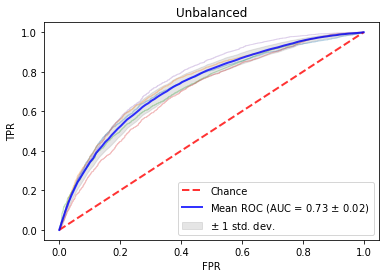

In [9]:
rocauc_curve(clf, X.values, y.values, folds=5, verbose=1, title='Unbalanced')

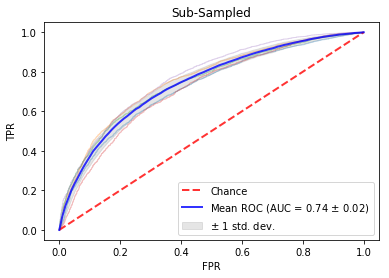

In [12]:
rocauc_curve(clf, X.values, y.values, folds=5, title='Sub-Sampled', verbose=1, balance_fcn=balanced_subsample)

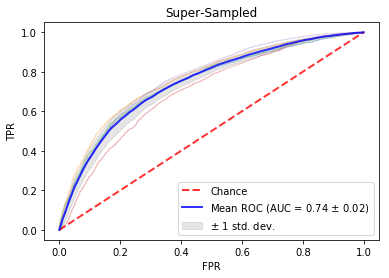

In [13]:
rocauc_curve(clf, X.values, y.values, folds=5, title='Super-Sampled', verbose=1, balance_fcn=balanced_supersample)

In [14]:
score_list = []
for fcn in [balanced_subsample, balanced_supersample, None]:
    print(fcn)
    if fcn:
        X_temp, y_temp = fcn(X.values, y.values)
        print(y_temp.shape)
        print(X_temp.shape)
    else:
        X_temp = X
        y_temp = y
    score_list.append(cross_validate(clf, 
                            X_temp, y_temp,
                            cv=5,
                            scoring=['accuracy', 'f1', 'recall', 'precision']
                        )
                     )

<function balanced_subsample at 0x7ff7ae9e07b8>
(24360,)
(24360, 129)


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


<function balanced_supersample at 0x7ff7ae9e0730>
(45084,)
(45084, 129)


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


None


In [15]:
nun = pd.DataFrame(score_list[0])
nun['kind'] = 'Unbalanced'
sub = pd.DataFrame(score_list[1])
sub['kind'] = 'Subsample'
sup = pd.DataFrame(score_list[2])
sup['kind'] = 'Supersample'

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:125: FutureWarni

In [16]:
comb = pd.concat([nun, sub, sup])

In [17]:
comb = comb.groupby('kind').mean()

In [18]:
comb.columns = ['Fit Time', 'Score Time', 'Accuracy', 'F1', 'Precision', 'Recall', 'train_accuracy', 'train_f1', 'train_precision', 'train_recall']
comb.head()

,Fit Time,Score Time,Accuracy,F1,Precision,Recall,train_accuracy,train_f1,train_precision,train_recall
kind,,,,,,,,,,
Subsample,174.070938,2.765050,0.655928,0.604187,0.597818,0.618501,0.691964,0.720753,0.660486,0.804466
Supersample,141.555200,3.040642,0.701803,0.791619,0.725076,0.875542,0.721085,0.805650,0.736877,0.891946
Unbalanced,89.615415,1.982302,0.467693,0.284706,0.538927,0.224959,0.703120,0.591844,0.770563,0.533147


Text(0, 0.5, 'Time (s)')

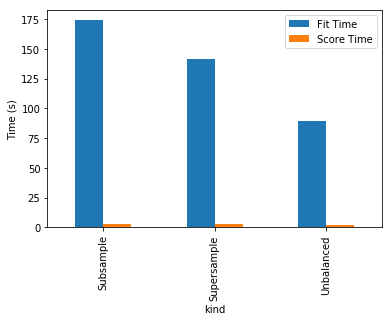

In [19]:
ax = comb.plot(y=['Fit Time', 'Score Time'],kind='bar')
ax.set_ylabel("Time (s)")

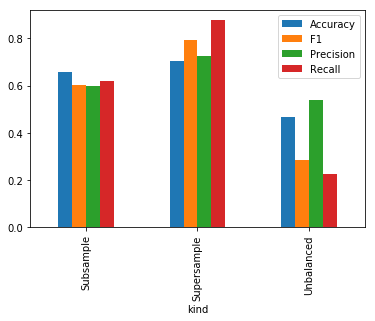

In [20]:
comb.plot(y=['Accuracy', 'F1', 'Precision', 'Recall'],kind='bar')